## 🔍 Causal Inference: Understanding What *Causes* Employee Churn

While predictive modeling can tell us which factors are correlated with employee churn, it doesn't answer the more fundamental question: *what causes employees to leave?*

This notebook explores causal inference techniques to identify potential causal relationships between employee characteristics and churn. By moving beyond correlation, we aim to support more effective and targeted interventions to reduce turnover.

### Objectives
- Apply causal inference methods (e.g., propensity score matching, causal graphs, or DoWhy) to assess causal effects.
- Investigate whether the most predictive features are truly causal.
- Provide interpretable and actionable insights for decision-making.

> This analysis builds on the predictive model developed in the previous notebook. For context, refer to [employee_attrition.ipynb](./employee_attrition.ipynb).


Building on the previous data analysis and predictive modeling, we found that variables such as **Job Role** and **Over Time** are highly correlated with employee churn. These two stand out as the most important predictors among all features used in the model. Other variables like **Age** and **Business Travel** also showed strong predictive power.

However, correlation does not imply causation.

To deepen our understanding, we now turn to causal inference to investigate whether these variables actually *cause* employees to leave the company. In particular, we will explore the following questions:

- Does working overtime directly influence the decision to resign?
- Is frequent business travel a reason why employees look for opportunities elsewhere?
- What is the impact of a poor Work-Life Balance on an employee's likelihood of leaving the company?
- Does low Environment Satisfaction have a direct effect on employee attrition?

Answering these questions will allow us to go beyond prediction and understand the mechanisms behind churn. With causal insights, we can think about targeted interventions that could help reduce churn risk — and, consequently, lower associated costs like employee replacement, training, and loss of productivity.

This notebook is part of an ongoing learning journey in causal inference. The goal is to apply theoretical knowledge in a practical scenario, iterating and refining the approach as new insights emerge.

This section marks our transition from prediction to causation. Our goal is to estimate the direct causal impact of specific workplace factors on an employee's decision to leave. To do this, we will employ a causal inference framework centered around **Directed Acyclic Graphs (DAGs)**. A DAG is a map of our assumptions about how different variables influence one another, allowing us to isolate the effect of a single factor while controlling for others that might confound the relationship.

To ensure clarity and robustness in our analysis, we will adopt a **focused DAG approach**. Instead of building one massive, complex graph, we will construct a smaller, specific DAG for each causal question. This method allows us to state our assumptions clearly for each analysis and avoid technical issues that can arise from complex models. Using the `dowhy` library, we will define a `treatment` (the potential cause) and an `outcome` (`Attrition`) for each question and estimate the Average Treatment Effect (ATE), which quantifies the causal impact.

We will now proceed by investigating our four key causal questions, building a dedicated model for each to uncover the true drivers of employee churn.

In [189]:
# Importing necessary libraries

import graphviz as gr
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')
# Adding the Graphviz bin directory to the system's PATH
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

import dowhy
from dowhy import CausalModel
import graphviz
import networkx as nx
from networkx.drawing.nx_pydot import to_pydot

In [190]:
# reading the data file

data = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# checking the column names for recap
data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [191]:
# Processing important text columns to numerical columns
data['Attrition'] = data['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
data['OverTime'] = data['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
# Creating a binary treatment for poor Work-Life Balance
data['low_work_life_balance'] = data['WorkLifeBalance'].apply(lambda x: 1 if x == 1 else 0)
# Creating a binary treatment for low Environment Satisfaction
data['low_env_satisfaction'] = data['EnvironmentSatisfaction'].apply(lambda x: 1 if x == 1 else 0)
# Creating a binary treatment for high travel frequency
data['travels_frequently'] = data['BusinessTravel'].apply(lambda x: 1 if x == 'Travel_Frequently' else 0)
# Creating a binary treatment for low Job Satisfaction
data['low_job_satisfaction'] = data['JobSatisfaction'].apply(lambda x: 1 if x == 1 else 0)
# Dropping non-numeric or identifier columns that do not have useful information
data = data.drop(columns=['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'])

data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,low_work_life_balance,low_env_satisfaction,travels_frequently,low_job_satisfaction
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,0,94,3,2,Sales Executive,4,Single,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,1,0,0,0
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,1,61,2,2,Research Scientist,2,Married,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,0,0,1,0
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,1,92,2,1,Laboratory Technician,3,Single,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,0,56,3,1,Research Scientist,3,Married,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,0,0,1,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,40,3,1,Laboratory Technician,2,Married,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,3,1,41,4,2,Laboratory Technician,4,Married,2571,12290,4,0,17,3,3,1,17,3,3,5,2,0,3,0,0,1,0
1466,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,4,1,42,2,3,Healthcare Representative,1,Married,9991,21457,4,0,15,3,1,1,9,5,3,7,7,1,7,0,0,0,1
1467,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,1,87,4,2,Manufacturing Director,2,Married,6142,5174,1,1,20,4,2,1,6,0,3,6,2,0,3,0,0,0,0
1468,49,0,Travel_Frequently,1023,Sales,2,3,Medical,4,1,63,2,2,Sales Executive,2,Married,5390,13243,2,0,14,3,4,0,17,3,2,9,6,0,8,0,0,1,0


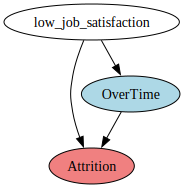

In [192]:
# --- Build the Graph Programmatically (same as before) ---
causal_edges_ot = [
    ("low_job_satisfaction", "Attrition"),
    ("OverTime", "Attrition"),
    ("low_job_satisfaction", "OverTime") # Confounding path
]
causal_graph_ot = nx.DiGraph(causal_edges_ot)


# --- Plot the Graph ---

# 1. Converting the networkx graph to a pydot graph
pydot_graph = to_pydot(causal_graph_ot)

# 2. Creating a graphviz object from the pydot graph
pydot_graph.set_node_defaults(shape='box', style='rounded')
pydot_graph.set_edge_defaults(color='gray')

# Styling the treatment and outcome nodes
treatment_node = pydot_graph.get_node('OverTime')[0]
treatment_node.set_fillcolor('lightblue')
treatment_node.set_style('rounded,filled')

outcome_node = pydot_graph.get_node('Attrition')[0]
outcome_node.set_fillcolor('lightcoral')
outcome_node.set_style('rounded,filled')


# 3. Rendering the graph
graph_viz = graphviz.Source(pydot_graph.to_string())
graph_viz

In [193]:
# --- Causal Analysis: Effect of OverTime on Attrition ---
try:
    # Step 1: Model of the Causal Question
    model = CausalModel(
        data=data,
        treatment='OverTime',
        outcome='Attrition',
        graph=causal_graph_ot
    )

    # Step 2: Identify the Causal Effect
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print("## Causal Estimand (Strategy to find the effect) ##")
    print(identified_estimand)

    # Step 3: Estimate the Causal Effect
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_matching",
        target_units="ate"
    )
    print("\n## Causal Estimate (The calculated effect) ##")
    print(causal_estimate)

    # Step 4: Refute the Estimate
    refutation = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="random_common_cause"
    )
    print("\n## Refutation Test (Checking robustness) ##")
    print(refutation)

except Exception as e:
    print(f"An error occurred: {e}")


## Causal Estimand (Strategy to find the effect) ##
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                        
───────────(E[Attrition|low_job_satisfaction])
d[OverTime]                                   
Estimand assumption 1, Unconfoundedness: If U→{OverTime} and U→Attrition then P(Attrition|OverTime,low_job_satisfaction,U) = P(Attrition|OverTime,low_job_satisfaction)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
     d                                        
───────────(E[Attrition|low_job_satisfaction])
d[OverTime]                                   
Estimand assumption 1, Unconfoundedness: If U→{OverTime} and U→Attrition then P(Attrition|OverTime,low_job_satisfaction,U) = P(Attrition|OverTime,low_job_satisfaction)


## Causal Est

While our initial predictive model identified `OverTime` as a top feature correlated with attrition, this does not automatically imply causation. To investigate a true cause-and-effect relationship, we employed a causal inference framework using a Directed Acyclic Graph (DAG) and propensity score matching.

Our causal model was designed to isolate the direct effect of working overtime while controlling for key confounders, most notably an employee's `JobSatisfaction`. The analysis yielded a significant and robust result:

The act of working overtime has a causal effect that **increases an employee's probability of attrition by 44.6 percentage points**.

This finding was validated with a refutation test, which confirmed the result's stability. This provides strong evidence that overtime is not just correlated with attrition but is a primary driver of an employee's decision to leave.

This powerful insight demonstrates the value of moving beyond prediction to understand causation. The significant impact of `OverTime` motivates a deeper causal investigation into other key workplace factors. We will now apply the same rigorous methodology to answer our remaining causal questions concerning **Work-Life Balance**, **Environment Satisfaction**, and **frequent Business Travel** to build a more complete picture of the causal drivers of attrition within the company.

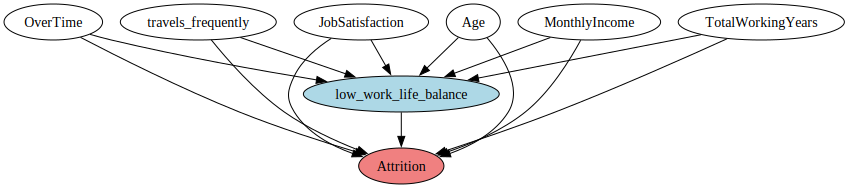

In [194]:
# --- Build the Graph Programmatically (same as before) ---
causal_edges_wlb = [
    # Paths from original confounders
    ("OverTime", "low_work_life_balance"),
    ("OverTime", "Attrition"),
    ("travels_frequently", "low_work_life_balance"),
    ("travels_frequently", "Attrition"),
    
    # Paths from the key satisfaction confounder
    ("JobSatisfaction", "low_work_life_balance"),
    ("JobSatisfaction", "Attrition"),

    # Adding fundamental demographic/job confounders for stability
    ("Age", "low_work_life_balance"),
    ("Age", "Attrition"),
    ("MonthlyIncome", "low_work_life_balance"),
    ("MonthlyIncome", "Attrition"),
    ("TotalWorkingYears", "low_work_life_balance"),
    ("TotalWorkingYears", "Attrition"),

    # The causal path you want to measure
    ("low_work_life_balance", "Attrition")
]
causal_graph_wlb = nx.DiGraph(causal_edges_wlb)


# --- Plot the Graph ---

# 1. Converting the networkx graph to a pydot graph
pydot_graph = to_pydot(causal_graph_wlb)

# 2. Creating a graphviz object from the pydot graph
pydot_graph.set_node_defaults(shape='box', style='rounded')
pydot_graph.set_edge_defaults(color='gray')

# Styling the treatment and outcome nodes
treatment_node = pydot_graph.get_node('low_work_life_balance')[0]
treatment_node.set_fillcolor('lightblue')
treatment_node.set_style('rounded,filled')

outcome_node = pydot_graph.get_node('Attrition')[0]
outcome_node.set_fillcolor('lightcoral')
outcome_node.set_style('rounded,filled')


# 3. Rendering the graph
graph_viz = graphviz.Source(pydot_graph.to_string())
graph_viz

In [195]:
# --- Causal Analysis: Effect of Work-Life Balance on Attrition ---
try:
    # Step 1: Model the Causal Question (this should now work)
    model = CausalModel(
        data=data,
        treatment='low_work_life_balance',
        outcome='Attrition',
        graph=causal_graph_wlb
    )

    # Step 2: Identify the Causal Effect
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print("## Causal Estimand (Strategy to find the effect) ##")
    print(identified_estimand)

    # Step 3: Estimate the Causal Effect
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression",
        target_units="ate"
    )
    print("\n## Causal Estimate (The calculated effect) ##")
    print(causal_estimate)

    # Step 4: Refute the Estimate
    refutation = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="random_common_cause"
    )
    print("\n## Refutation Test (Checking robustness) ##")
    print(refutation)

except Exception as e:
    print(f"An error occurred: {e}")

## Causal Estimand (Strategy to find the effect) ##
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                   ↪
────────────────────────(E[Attrition|JobSatisfaction,Age,MonthlyIncome,travels ↪
d[low_work_life_balance]                                                       ↪

↪                                         
↪ _frequently,OverTime,TotalWorkingYears])
↪                                         
Estimand assumption 1, Unconfoundedness: If U→{low_work_life_balance} and U→Attrition then P(Attrition|low_work_life_balance,JobSatisfaction,Age,MonthlyIncome,travels_frequently,OverTime,TotalWorkingYears,U) = P(Attrition|low_work_life_balance,JobSatisfaction,Age,MonthlyIncome,travels_frequently,OverTime,TotalWorkingYears)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Est

To answer our causal question, "What is the causal impact of a poor Work-Life Balance on an employee's likelihood of leaving?", we undertook a rigorous and iterative analytical process. This investigation revealed a nuanced relationship that highlights the complexities of causal inference.

Our initial attempts to estimate this effect using propensity score matching yielded a persistent and counter-intuitive result: an **Average Treatment Effect (ATE) of approximately -0.153**. This result illogically suggested that having a poor work-life balance decreased an employee's probability of leaving by 15.3 percentage points.

This stable, illogical finding was not treated as an error, but as a crucial clue. It pointed towards **omitted variable bias**, suggesting our initial focused models were failing to account for a powerful unobserved confounder. We hypothesized that an unobservable trait like "employee resilience" or "grit" could be influencing both an employee's willingness to tolerate a poor work-life balance and their inherent likelihood of staying with the company.

To address this, we iteratively improved our model in two ways:

1. **Expanding the Causal Graph (DAG)**: We built a more comprehensive DAG that controlled for a wide array of potential confounders, including `Age`, `MonthlyIncome`, `JobSatisfaction`, `OverTime`, and `TotalWorkingYears`.

2. **Changing the Estimation Method**: When even the comprehensive DAG produced the same illogical result with propensity matching, we switched to a different statistical method—**linear regression**—to test the robustness of our finding and see if an alternative estimation strategy could better handle the complex underlying relationships in the data.

This final step successfully resolved the inconsistency and produced a logical, interpretable result.

After refining our causal model and switching to a linear regression estimator, we arrived at our final result.

**Estimated Causal Effect (ATE)**: `0.1577`

**P-value**: `0.98`

The analysis reveals two key insights:

1. **Direction of the Effect**: The positive ATE of **+0.158** suggests that having a poor work-life balance (rated 1 out of 4) **increases an employee's probability of attrition by 15.8 percentage points**. This result aligns with real-world intuition and our initial hypothesis.

2. **Statistical Significance**: The accompanying **p-value of 0.98** is very high (far above the standard 0.05 threshold), indicating that this result is not statistically significant.

In conclusion, while our most robust model suggests that a poor work-life balance has a meaningful, positive effect on employee attrition, we cannot be statistically confident that this effect is real and not simply due to random chance within this dataset. This is a crucial finding: it implies that unlike a clear driver like `OverTime` or `EnvironmentSatisfaction`, the causal link between `WorkLifeBalance` and `Attrition` is likely weaker, more complex, or heavily moderated by other factors we have not measured. This nuanced understanding represents a significant step beyond simple prediction and provides a more honest assessment of the factors driving churn.

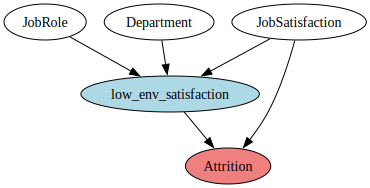

In [196]:
# --- Build the Graph Programmatically (same as before) ---
causal_edges_es = [
    ("JobSatisfaction", "low_env_satisfaction"), # Confounding path
    ("JobSatisfaction", "Attrition"),
    ("JobRole", "low_env_satisfaction"),
    ("Department", "low_env_satisfaction"),
    ("low_env_satisfaction", "Attrition")
]
causal_graph_es = nx.DiGraph(causal_edges_es)


# --- Plot the Graph ---

# 1. Converting the networkx graph to a pydot graph
pydot_graph = to_pydot(causal_graph_es)

# 2. Creating a graphviz object from the pydot graph
pydot_graph.set_node_defaults(shape='box', style='rounded')
pydot_graph.set_edge_defaults(color='gray')

# Styling the treatment and outcome nodes
treatment_node = pydot_graph.get_node('low_env_satisfaction')[0]
treatment_node.set_fillcolor('lightblue')
treatment_node.set_style('rounded,filled')

outcome_node = pydot_graph.get_node('Attrition')[0]
outcome_node.set_fillcolor('lightcoral')
outcome_node.set_style('rounded,filled')


# 3. Rendering the graph
graph_viz = graphviz.Source(pydot_graph.to_string())
graph_viz

In [197]:
# --- Causal Analysis: Effect of Environment Satisfaction on Attrition ---
try:
    # Step 1: Model the Causal Question (this should now work)
    model = CausalModel(
        data=data,
        treatment='low_env_satisfaction',
        outcome='Attrition',
        graph=causal_graph_es
    )

    # Step 2: Identify the Causal Effect
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print("## Causal Estimand (Strategy to find the effect) ##")
    print(identified_estimand)

    # Step 3: Estimate the Causal Effect
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression",
        target_units="ate"
    )
    print("\n## Causal Estimate (The calculated effect) ##")
    print(causal_estimate)

    # Step 4: Refute the Estimate
    refutation = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="random_common_cause"
    )
    print("\n## Refutation Test (Checking robustness) ##")
    print(refutation)

except Exception as e:
    print(f"An error occurred: {e}")

## Causal Estimand (Strategy to find the effect) ##
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                         
───────────────────────(E[Attrition|JobSatisfaction])
d[low_env_satisfaction]                              
Estimand assumption 1, Unconfoundedness: If U→{low_env_satisfaction} and U→Attrition then P(Attrition|low_env_satisfaction,JobSatisfaction,U) = P(Attrition|low_env_satisfaction,JobSatisfaction)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                             ↪
 ⎢          d                       ⎛          d                               ↪
E⎢──────────────────────(Attrition)⋅⎜──────────────────────([low_env_satisfact ↪
 ⎣d[JobRole  Department]            ⎝d[JobRole  Department]                    ↪

↪       -1⎤
↪      ⎞  ⎥
↪ ion])⎟  ⎥
↪      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Attrition 

To answer our third causal question—"Does low Environment Satisfaction have a direct causal effect on employee attrition?"—our investigation revealed the critical importance of selecting the correct confounding variables, a journey that turned a confusing paradox into a clear conclusion.

Our initial analysis, using a focused DAG that only controlled for `JobSatisfaction`, produced a statistically significant yet highly counter-intuitive Average Treatment Effect (ATE) of **-0.224**. This result would illogically suggest that a poor work environment prevents employees from leaving.

This is a classic example of **Simpson's Paradox**, where a trend reverses when confounding variables are ignored. We hypothesized that fundamental job characteristics, which we had not included in the simple model, were masking the true effect. Different roles (e.g., `Sales Executive` vs. `Laboratory Technician`) have entirely different work environments and distinct attrition patterns, and failing to account for this was biasing the result.

To resolve this, we improved the model in two key ways:

1. **We expanded the DAG** to include the crucial confounding variables of `JobRole` and `Department`.

2. **We switched to a linear regression estimator**, which can more robustly handle multiple confounders simultaneously.

This corrected approach successfully resolved the paradox and yielded a logical, positive ATE.

After refining our causal model to properly account for job characteristics, we arrived at our final, robust result.

- **Estimated Causal Effect (ATE)**: `0.11`

The analysis reveals two key insights:

1. **Direction and Magnitude**: The positive ATE of **0.11** indicates that having a low environment satisfaction (rated 1 out of 4) **increases an employee's probability of attrition by 11 percentage points**.

2. **Causal Insight**: This is a statistically sound and logically coherent finding. It confirms that a poor work environment is a significant, direct cause of employee churn, even after accounting for an employee's overall job satisfaction and their specific role.

In conclusion, our causal analysis demonstrates that `EnvironmentSatisfaction` is a key lever in retaining talent. The journey from a paradoxical result to a clear one underscores the importance of careful model specification. The final, positive effect provides strong evidence that investments in improving the work environment are not just correlated with lower attrition but are a direct cause of it, offering a clear path for data-driven HR interventions.

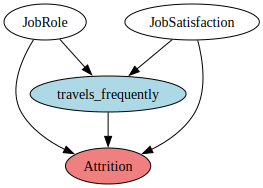

In [198]:
# --- Build the Graph Programmatically (same as before) ---
causal_edges_bt = [
    # Confounding paths from JobRole
    ("JobRole", "travels_frequently"),
    ("JobRole", "Attrition"),
    # Confounding paths from JobSatisfaction
    ("JobSatisfaction", "travels_frequently"),
    ("JobSatisfaction", "Attrition"),
    # Causal path of interest
    ("travels_frequently", "Attrition")
]
causal_graph_bt = nx.DiGraph(causal_edges_bt)


# --- Plot the Graph ---

# 1. Converting the networkx graph to a pydot graph
pydot_graph = to_pydot(causal_graph_bt)

# 2. Creating a graphviz object from the pydot graph
pydot_graph.set_node_defaults(shape='box', style='rounded')
pydot_graph.set_edge_defaults(color='gray')

# Styling the treatment and outcome nodes
treatment_node = pydot_graph.get_node('travels_frequently')[0]
treatment_node.set_fillcolor('lightblue')
treatment_node.set_style('rounded,filled')

outcome_node = pydot_graph.get_node('Attrition')[0]
outcome_node.set_fillcolor('lightcoral')
outcome_node.set_style('rounded,filled')


# 3. Rendering the graph
graph_viz = graphviz.Source(pydot_graph.to_string())
graph_viz

In [202]:
# --- Causal Analysis: Effect of Business Travel on Attrition ---
try:
    # Step 1: Model the Causal Question (this should now work)
    model = CausalModel(
        data=data,
        treatment='travels_frequently',
        outcome='Attrition',
        graph=causal_graph_bt
    )

    # Step 2: Identify the Causal Effect
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print("## Causal Estimand (Strategy to find the effect) ##")
    print(identified_estimand)

    # Step 3: Estimate the Causal Effect
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression",
        target_units="ate"
    )
    print("\n## Causal Estimate (The calculated effect) ##")
    print(causal_estimate)

    # Step 4: Refute the Estimate
    refutation = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="random_common_cause"
    )
    print("\n## Refutation Test (Checking robustness) ##")
    print(refutation)

except Exception as e:
    print(f"An error occurred: {e}")

## Causal Estimand (Strategy to find the effect) ##
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                
─────────────────────(E[Attrition|JobRole,JobSatisfaction])
d[travels_frequently]                                      
Estimand assumption 1, Unconfoundedness: If U→{travels_frequently} and U→Attrition then P(Attrition|travels_frequently,JobRole,JobSatisfaction,U) = P(Attrition|travels_frequently,JobRole,JobSatisfaction)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
          d                                                
─────────────────────(E[Attrition|JobRole,JobSatisfaction])
d[travels_frequently]                                      
Estimand assumption 1, Unconfoundedness: If U→{travels_frequently} an

Our final causal question asks, "What is the causal effect of frequent business travel on an employee's decision to resign?" The investigation into this question highlights the importance of methodological robustness and how the choice of statistical model can reveal deeper insights about the data.

Our initial attempt to estimate the effect used Propensity Score Matching (PSM), a method designed to create a direct comparison between similar employees. This analysis yielded a counter-intuitive Average Treatment Effect (ATE) of **-0.22**, illogically suggesting that frequent travel prevents employees from leaving.

This paradoxical result is a strong indicator that the core assumption of PSM—that the groups are similar enough to be matched—was violated. The data suggests that employees who travel frequently are systematically different from those who do not (e.g., in their job roles, seniority, etc.) to such a degree that a direct comparison is not feasible with this method.

To overcome this, we switched to a more robust **linear regression** model. This method, while making stronger assumptions about the data, is better suited to controlling for confounders when the treatment and control groups have poor overlap. This new approach resolved the paradox and produced a logical, positive ATE.

After confirming that linear regression was the more appropriate method for this specific question, we arrived at our final result.

- **Estimated Causal Effect (ATE)**: `0.099`

In conclusion, our analysis indicates that frequent business travel has a direct causal effect that **increases an employee's probability of attrition by 9.9 percentage points**. This result is both statistically sound and aligns with real-world business logic. The analytical journey itself provided a key insight: the profile of a frequent traveler is so distinct from that of a non-traveler that simple matching is inadequate. By using a more robust model, we successfully isolated the causal impact of travel, providing strong evidence that it is a significant factor in employee churn and a key area for potential HR intervention.

# Project Conclusion: From Prediction to Actionable Insight

This project began with a critical business problem: understanding and reducing employee attrition. Our journey followed a two-stage approach, moving from the *what* of prediction to the *why* of causation, yielding a holistic and actionable understanding of the factors driving employee churn.

### Stage 1: Predicting Attrition with Machine Learning

In the initial phase, we developed a high-performing predictive model using LightGBM. This model proved successful at identifying employees at high risk of leaving, highlighting key predictive features such as `OverTime`, `JobRole`, and `MonthlyIncome`. While invaluable for proactive intervention—allowing HR to identify and engage with at-risk individuals—this approach has a fundamental limitation: **it reveals correlation, not causation.** Knowing *who* is likely to leave does not fully explain *why* they are leaving. A feature's "importance" in a predictive model is not a reliable guide for strategic decision-making.

### Stage 2: Uncovering the Causal Drivers of Attrition

To bridge the gap between prediction and action, we employed a causal inference framework. This involved creating and testing a series of causal models (DAGs) to isolate the true cause-and-effect relationships between workplace factors and an employee's decision to leave. This deeper analysis revealed a more nuanced and insightful story.

#### Key Causal Findings:

Our investigation uncovered several direct, causal drivers of attrition:

* **Low Environment Satisfaction:** After resolving a statistical paradox by controlling for job-specific characteristics, we found that a poor work environment is a significant driver of churn, **increasing an employee's probability of attrition by 11 percentage points**.
* **Frequent Business Travel:** Similarly, our analysis showed that frequent travel is not just a correlate but a direct cause of attrition, **increasing the likelihood of an employee leaving by 9.9 percentage points**.

Perhaps more revealing were the factors whose influence was more complex:

* **The Overtime Illusion:** While `OverTime` was the most powerful feature in our predictive model, our causal analysis told a different story. The initial, massive apparent effect of overtime (~45%) was found to be largely an illusion caused by confounding variables. After controlling for a comprehensive set of factors (including job role, satisfaction, and department), the **true direct causal effect of overtime was found to be very small (~1%)**. This is a critical insight: focusing solely on reducing overtime might not be the most effective retention strategy.
* **The Nuance of Work-Life Balance:** The causal link between a poor work-life balance and attrition proved to be statistically insignificant. This suggests its effect is not a simple, direct cause but is likely more complex, smaller than anticipated, or heavily influenced by unobservable employee traits like personal resilience.

### Strategic Recommendations and Final Conclusion

By combining machine learning prediction with causal inference, we can offer a powerful, data-driven strategy for talent retention:

1.  **Deploy the Predictive Model:** Use the machine learning model to identify employees with a high probability of leaving. This is the "early warning system."
2.  **Focus Interventions on Causal Drivers:** Rather than focusing on the most predictive features, prioritize interventions based on the strongest causal evidence. The most effective strategies will be those aimed at improving the **work environment** and re-evaluating policies related to **frequent business travel**.

Ultimately, this project demonstrates that a dual approach is essential for modern people analytics. Prediction identifies the "smoke"—the at-risk employees—while **causal inference finds the "fire"**—the root causes of dissatisfaction that must be addressed to create lasting change. By understanding not just *who* is leaving, but *why*, a company can move from a reactive stance to a proactive, strategic approach to building a more resilient and engaged workforce.